# Chapter 14
# Convolutional Neural Networks

## Understanding the Visual Cortex

David H. Huble and Torsten Wiesel showed, in 1981, that many neurons in the visual cortex have a small *local receptive field*, meaning they only react to visual stimuli in a limited region of the visual field. They also showed that some neuros react only to images of horizontal lines, while others reacted to images of line with different orientations. Furthermore, some neurons have larger receptive fields and react to more complex patterns that are combinations of the lower level patterns. (see fig. 14.1 page 447) 

These discoveries inspired the [neocognitron](https://homl.info/74) which evolved into **convolutional neural networks**. A major mileston came with the [1998 paper by Yann LeCunn](https://homl.info/75) which introduced the *LeNet-5* architecture, with convolutional layers and pooling layers.

## Convolutional Layers

A *convolutional layer* tries to mimic the way neurons have a local receptive field. Instead of being connected to every single pixel in the input image, they are connected only to pixels in their receptive fields. (fig 14-2 pg 448). In the second convolutional layer, each neuron is only connected to neurons within a small rectangle in the first layer.

This way, the network concentrates on small low-level features in the first hidden layer, then assembles them into larger higher-level features in the next hidden layer and so on. CNNs work so well for image recognition because this hierarchical structure is part of real world imagery

For this architecture, we have to define $f_h$ and $f_w$, the height and width of the receptive fields. This way, a neuron in row $i$, column $j$ is connected to the outputs of the neurons in the previous layer located in rows $i$ to $i+f_h-1$, columns $j$ to $j + f_w -1$ (see fig 14-3 pg 449). In order to maintain the same height and widht as previous layers, it is common to add zeros around the inputs. This is called *zero padding*.

We can also connect a larger input layer to a much smaller layer by spacing out the receptive fields (figure 14-4), reducing computational complexity. The shift from one receptive field to another is called the *stride* ($s_h$ for height, $s_w$ for width). A neuron located in row $i$, column $j$ n the upper layer is connected to outputs of neurons in the previous layer located in rows $i \times s_h$ to $i\times s_h + f_h -1$, columns $j \times s_w$ to $j\times s_w + f_w -1$

### Filters

Neuron's weights can be represented as a small image the size of the receptive field. Figure 14-4 shows two sets of weights called *filters* (or *convolution kernels*). Ther first one is a black square with a vertical white line in the middle (a 7x7 matrix full of zeros except for the central columns which is full of 1s). Neurons using these weights will ignore everything in their receptive fields except for the middle. The second filter is a black square with a horizontal white line in the middle, working the same way.

Figure 14-4 shows the result of feeding an image to both filters. With the horizontal filters, horizontal lines get enhanced while the rest is blurred out. Thus, a layer full of neurons using the same filter outputs a *feature map*, which highlights the areas in an image that activate the filter the most. 

Filters do not have to be defined manually. Instead, during training the convolutional layer will automatically learn the most useful filters for its task, with higher level layers contributing to more complex patterns

### Stacking multiple feature maps

In practice, a convolutional layer has many filters (you decide how many) and outputs one feature map per filter, so it is more accurately represented in 3D (figure 14-6 pg 452). It has one neuron per pixel in each feature map and all neurons within a given feature map share the same parameters (i.e. weights and bias term). Neurons in different feature maps use different parameters. The receptive fields are the same, but extending across all the previous layers feature maps. In summary, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.

Specifically, a neuron in row $i$, column $j$ of feature map $k$ in a given convolutional layer $l$ is connected to the outputs of the neurons in the previous layer $l-1$ located in rows $i\times s_h$ to $i\times s_h + f_h -1$ and columns $j\times s_w$ to $j\times s_w + f_w -1$ across all feature maps.

The following equation summarizes the above: it shows how to compute the output of a given neuron in a convolutional layer. 

$$ z_{i,j,k} = b_k + \sum_{u=0}^{f_h-1}\sum_{v=0}^{f_w-1}\sum_{k'=0}^{f_{n'}-1} x_{i', j', k'} \times w_{u,v,k', k} \text{ with } \begin{cases} i'= i\times s_h +u \\ j'= j\times s_w + v \end{cases}$$

Where
* $z_{i,j,k}$ is the output of the neuron located in row $i$, column $j$ in feature map $k$ of convolutional layer $l$
* $s_h, s_w$ are the vertical and horizontal strides
* $f_h, f_w$ are the height and width of the receptive field and $f_{n'}$ is the number of feature maps in the previous layer (layer $l-1$)
* $b_k$ is the bias term for feature map $k$ (in layer $l$). You can think of it as a knob that tweaks the overall brightness of feature map $k$
* $w_{u, v, k', k}$ is the connection weight between any neuron in feature map $k$ of the layer $l$ and its input located at row $u$, column $v$ and feature map $k'$

### Tensorflow Implementation

In TF, each input image is typically represented as a 3D tensor of shape _[height, width, channels]_. A mini batch is a 4D tensor of shape _[mini-batch size, height, width, channels]_. The weights of a convolutional layer are represented as 4d tensor of shape $[f_h, f_w, f_{n'}, f_n]$. The bias are simply represented as a 1D tensor of shape $[f_n]$.

Let's look at an example

In [23]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
from sklearn.datasets import load_sample_image
import matplotlib as mpl
import matplotlib.pyplot as plt

In [22]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [4]:
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

<function matplotlib.pyplot.show(*args, **kw)>

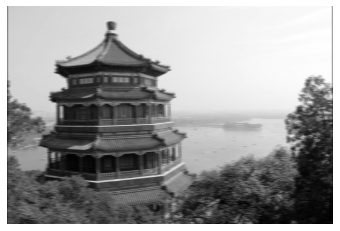

In [25]:
# Create two filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # vertical line

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

plt.imshow(outputs[0, :, :, 1], cmap='gray') # 1st img, 2nd feature map
plt.axis('off')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

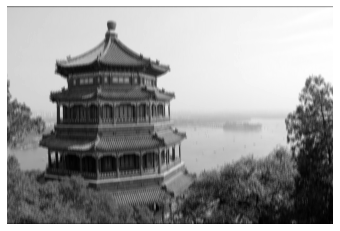

In [28]:
plt.imshow(outputs[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show

```tf.nn.conv2d()``` deserves a bit more detail:
* ```images``` is the input mini batch
* ```filters``` is the set of filters to apply
* ```strides``` is equal to 1
* ```padding``` must be either 'SAME' or 'VALID'
    - SAME means we use zero padding if necessary
    - VALID means we do not use padding and may ignore some rows and columns at the bottom and right of the input image, depending on the stride. Hence every neuron's receptive  field lies strictly within valid positions inside the input and thus, the name

In the example above we manually set the filters, but in reality the filters are trainable variables so the neural net can learn which ones work best. here's an example with a Keras layer

In [29]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')

### Memory Requirements

Due to their architecture, CNNs require a huge amount of RAM, especially during training because of the reverse pass of backpropagation.

Example:

A convolutional layer with $5\times5$ filters, outputting 200 feature maps of size $150\times 100$, with stride 1 and "same" padding. If the input is a $150\times 100$ RGB image (3 channels), then the number of parameters is $(5\times 5\times 3 + 1)\times 200 = 15,200$. 

This is small, when comparered to a fully connected layer. However each of the 200 feature maps contains $150\times 100$ neurons and each of these needs to comput a weighted sum of its $5\times 5 \times 3=75$ inputs, yielding a total of 225 million float multiplications. If the feature maps are represented using 32-bit floats, the convolutional layer's output will occupy $200\times150\times100\times32 = 96$ million bits (12 MB) of RAM. And that's just for one instance, with 100 training instances this layer occupies 1.2 GB or RAM!

*Tip:* If training crashes because of out of memory error, you can try reducing the mini-batch size. You can also try reducing dimensionality using a stride or removing a few layers. You can also try 16-bit floats instead of 32 bits. FInally you can also distribute the CNN across multiple devices!

## Pooling Layers